In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
# plt.style.use('ggplot')
get_ipython().run_line_magic('matplotlib', 'inline')
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

from tqdm import tqdm

from fitter import Fitter, get_common_distributions, get_distributions
from sklearn.model_selection import train_test_split

import random
import math

from collections import Counter

import warnings
warnings.filterwarnings('ignore')

In [2]:
def drop_bug_st(df, max_score):

    proxy = df.groupby('session_id').sum()
    index_ch = proxy[proxy['max_score'] <= max_score].index
    
    df = df[df['session_id'].isin(index_ch)]
    
    return df

def plot_scores(df):
    all_scores = np.array(df[['session_id', 'score']].groupby('session_id').sum())
    plt.xlabel('Число решенных задач')
    plt.ylabel('Количество студентов с таким скором')
    plt.hist(all_scores)
    plt.show()
    
def plot_students(df):
    all_students = np.array(df[['session_id', 'school_id']].groupby('school_id').count())
    plt.xlabel('Число студентов в школе')
    plt.ylabel('Количество школ с таким числом студентов')
    plt.hist(all_students)
    plt.show()
    
    plt.xlabel('Число студентов в школе')
    plt.ylabel('Количество школ с таким числом студентов')
    plt.hist(all_students[all_students < 200])    
    plt.show()
    
def parewise_stat(n):
    return n * (n - 1) / 2

def metric_sim_wrong_ans_weighted_other(df, tasks):
    
    '''
    tasks - список номеров заданий
    '''
    
    X = df.copy()
    X = X[X['verdict'] == 'wrong']
    
    ans_dict = dict(zip(list(X['school_id'].unique()), np.zeros(len(list(X['school_id'].unique())))))
    
    for sch in ans_dict.keys():
        Y = X[X['school_id'] == sch]
        for i in range(len(tasks)):
            one_more_dict = Counter(Y[Y['task_no'] == tasks[i]]['users_answer'])
            stat = np.array(list(one_more_dict.values()))
            ans_dict[sch] += np.sum(parewise_stat(stat[stat > 1]))
            
                    
    return np.array(list(ans_dict.values())), list(ans_dict.keys())

def plot_scatter_stud_vs_metric(studs, res):
    plt.scatter(studs, res)
    plt.xlabel('Количество школьников в школе')
    plt.ylabel('Значение метрики')
    plt.show()
    
def plot_log_metric(log_all_t_weighted):
    plt.hist(log_all_t_weighted)
    plt.xlabel('Значение метрики')
    plt.ylabel('Количество школ с такой метрикой')
    plt.show()
    
def get_best_distribution(log_all_t_weighted):
    data_train, data_test = train_test_split(log_all_t_weighted, test_size=0.3, random_state=42)
    f = Fitter(data_train,
           distributions= ['gamma',
                          'beta',
                          'burr',
                          'gengamma'])
    f.fit()
    f.summary()
    plt.show()
    
    best_dist = f.get_best(method = 'sumsquare_error')
    dist_name = list(best_dist.keys())[0]
    a, b, loc, scale = f.fitted_param['beta']
    res_train = ss.probplot(data_train, sparams=(a, b, loc, scale), dist='beta', plot=plt, fit=True)
    plt.show()
    res_test = ss.probplot(data_test, sparams=(a, b, loc, scale), dist='beta', plot=plt, fit=True)
    plt.show()
    
    print(f'p-value того, что train и test принадлежат одному распределению: {ss.ks_2samp(data_train, data_test).pvalue}')
    
    params = ss.beta.fit(data_train)
    return ss.beta(*params)

def get_dict_of_wr_ans_probs(df):
    X = df.copy()
    X = X[X['verdict']=='wrong']
    all_wrong_ans_dict = {}
    for i in range(1, 9):
        all_wrong_ans_dict[i] = dict(Counter(X[X['task_no'] == i]['users_answer']))
        
    for key in all_wrong_ans_dict.keys():
        s_wrong_i = sum(all_wrong_ans_dict[key].values())
        for key1 in all_wrong_ans_dict[key].keys():
            all_wrong_ans_dict[key][key1] = all_wrong_ans_dict[key][key1] / s_wrong_i
            
    return all_wrong_ans_dict

def get_wrong_ans(num_task, num_studs, distribution_dict):
    '''
    num_task - номер задания
    num_studs - количество студентов
    distribution_dict - словарь с распределением (см. предыдущую функцию)
    '''
    draw = np.random.choice(list(distribution_dict[num_task].keys()), num_studs, p=list(distribution_dict[num_task].values()), replace=True)
    return draw

def f(obs):
    if obs == 0:
        return 'wrong'
    else:
        return 'ok'
    
def get_task_id(num_studs, num_tasks):
    ans = [1] * num_studs
    for i in range(2, num_tasks + 1):
        ans.extend([i] * num_studs)
        
    return ans

def true_students(n, num_of_tasks, school_id, array_emp_dist_of_correct, dict_emp_dist_of_wrong_ans):
    
    '''
    если генерировать честных студентов из вероятностей каждого задания
    '''
    
    dim = n * num_of_tasks
    results = ss.bernoulli(array_emp_dist_of_correct).rvs(size=(n, num_of_tasks))
    score = results.flatten()
    all_answers = get_wrong_ans(1, n, dict_emp_dist_of_wrong_ans)
    for i in range(2, num_of_tasks+1):
        all_answers = np.concatenate((all_answers, get_wrong_ans(i, n, dict_emp_dist_of_wrong_ans)))
        
    school_ids = dim * [school_id]
    stud_id = np.array(range(0, dim)) % n + 1
    
    task_id = get_task_id(n, num_of_tasks)
    
    d = {
        'session_id': stud_id, 'task_no': task_id, 'score': score, 'school_id': school_ids, 'users_answer': all_answers, 
    }
            
    d = pd.DataFrame(data=d)
    d['verdict'] = d['score'].apply(f)
    return d

def cheat_students(max_studs_in_cluster, clusters, num_of_tasks, school_id, array_emp_dist_of_correct, dict_emp_dist_of_wrong_ans):
    
    '''
    генерация нечестных студентов из вероятностей
    '''
    
    X = true_students(1, num_of_tasks, school_id, array_emp_dist_of_correct, dict_emp_dist_of_wrong_ans)
    X['session_id'] = X['session_id'] + 900
    
    for i in range(clusters):
        stud_in_sample_cluster = random.randint(2, max_studs_in_cluster)
        Y = true_students(1, num_of_tasks, school_id, array_emp_dist_of_correct, dict_emp_dist_of_wrong_ans)
        Y = pd.concat([Y] * stud_in_sample_cluster)
        Y['session_id'] = np.array(range(0, stud_in_sample_cluster * num_of_tasks)) // num_of_tasks + 1 + 1000 + 100 * i
        X = pd.concat([X, Y])
        
    return X.reset_index(drop=True)

def generate_cheat_school(share_of_true, n, num_of_tasks, school_id, array_emp_dist_of_correct, dict_emp_dist_of_wrong_ans, max_studs_in_cluster=6):
    '''
    share_of_true - доля честных учеников
    n - среднее количество всех учеников 
    num_of_tasks - количество заданий
    school_id - id школы
    array_emp_dist_of_correct - распределение вероятностей правильного решения каждого задания
    dict_emp_dist_of_wrong_ans - распределение неправильных ответов
    max_studs_in_cluster - максимум школьников в кластере
    '''
    
    n_true = int(n * share_of_true)
    n_cheat = n - n_true
    
    test_df_true = true_students(n_true, num_of_tasks, school_id, array_emp_dist_of_correct, dict_emp_dist_of_wrong_ans)
    
    num_of_clusters = random.randint(1, n_cheat // 2)
    max_cheat_studs_per_cluster = n_cheat // num_of_clusters + 1
    
    test_df_cheat = cheat_students(max_cheat_studs_per_cluster, num_of_clusters, num_of_tasks, school_id, array_emp_dist_of_correct, dict_emp_dist_of_wrong_ans)
    
    return pd.concat([test_df_true, test_df_cheat]).reset_index(drop=True)

def get_true_power(n, sample):
    left_border = n > np.mean(n) - np.std(n)
    right_border = n < np.mean(n) + np.std(n)
    x = sample * right_border * left_border
    y = n * right_border * left_border
    return y[y != 0], x[x != 0]

def power_experiment(emp_p, all_wr_ans_probs, crytical_value, share_of_true_studs=0.7, number_of_students=50, tasks=8, rep=100):
    stat_cheat = np.zeros(rep)
    students_at_cheat = np.zeros(rep)

    for i in tqdm(range(rep)):
        test_cheat_df = generate_cheat_school(share_of_true_studs, number_of_students, tasks, 1, emp_p, all_wr_ans_probs)
        up = metric_sim_wrong_ans_weighted_other(test_cheat_df, np.array(range(1, tasks+1)))[0]
        down = (test_cheat_df.shape[0] / tasks) ** 2
        stat_cheat[i] =  np.log(up / down)
        students_at_cheat[i] = test_cheat_df.shape[0] / tasks
        
    ad_studs, ad_power = get_true_power(students_at_cheat, stat_cheat)

    print(f'Доля обнаруженных нечестных школ: {len(ad_power[ad_power > crytical_value]) / len(ad_power)}')
    plt.hist(ad_power)
    plt.axvline(x=crytical_value, c='r')
    plt.show()
    
def df_school_with_metric(school_ids, num_students, metric_raw):
    metric_not_logged = metric_raw / num_students ** 2
    d = {'schools': school_ids, 'metric_not_logged': metric_not_logged}
    df_return = pd.DataFrame(data=d)
    df_return = df_return[df_return['metric_not_logged'] > 0]
    df_return['metric_logged'] = np.log(df_return['metric_not_logged'])
    return df_return

def aa_experiment(emp_p, all_wr_ans_probs, crytical_value, share_of_true_studs=1, tasks=8, rep=100):
    
    stat_cheat = np.zeros(rep)
    students_at_cheat = np.zeros(rep)

    for i in tqdm(range(rep)):
        number_of_students = random.randint(10, 500)
        test_df = true_students(number_of_students, tasks, 1, emp_p, all_wr_ans_probs)
        up = metric_sim_wrong_ans_weighted_other(test_df, np.array(range(1, tasks+1)))[0]
        down = (number_of_students) ** 2
        stat_cheat[i] =  np.log(up / down)
        
    print(f'Доля отмеченных честных школ: {len(stat_cheat[stat_cheat > crytical_value]) / len(stat_cheat)}')
    plt.hist(stat_cheat)
    plt.axvline(x=crytical_value, c='r')
    plt.show()
    
    return np.quantile(stat_cheat, q=0.95)

In [24]:
def shuffle_school(df):
    df_test = df[['session_id', 'school_id']]
    df_test = df_test.drop_duplicates(subset=['session_id'])
    df_test['school_id'] = np.random.permutation(df_test['school_id'].values)
    X = df.copy()
    X = X.merge(df_test, on='session_id')
    X = X.drop(columns=['school_id_x'])
    X = X.rename(columns={'school_id_y':'school_id'})
    return X

def new_aa_experiment(df, crytical_value, tasks=8, rep=1):
    
    res = 0
    
    for i in tqdm(range(rep)):
    
        test_df = shuffle_school(df)
        up = metric_sim_wrong_ans_weighted_other(test_df, np.array(range(1, tasks+1)))[0]
        down = (np.array(test_df[['session_id', 'school_id']].groupby('school_id').count()).flatten()) ** 2
        dim = min(len(up), len(down))
        stat_cheat = np.log(up[:dim] / down[:dim])
        stat_cheat = stat_cheat[stat_cheat > -100]

        res += np.quantile(stat_cheat, q=0.95)

    plt.hist(stat_cheat)
    plt.axvline(x=crytical_value, color='r')
    plt.show()
    
    return res / rep

def make_cheat_school(test_df, schools, share_of_cheat):
    dfs = test_df[test_df['school_id'] == random.choice(schools)]
    students = dfs['session_id'].unique()
    n_cheat = int(dfs.shape[0] * share_of_cheat)
    
    ans = dfs.copy()
    
    for i in range(n_cheat):
        to_append = dfs[dfs['session_id'] == random.choice(students)]
        ans = pd.concat([ans, to_append], ignore_index=True)
        
    return ans

def new_power_experiment(df, crytical_value, share_of_cheat=0.3, tasks=8, rep=100):
    schools = df['school_id'].unique()
    test_df = shuffle_school(df)
    
    res_stats = np.zeros(rep)
    for j in tqdm(range(rep)):
        try:
            sample = make_cheat_school(test_df, schools, share_of_cheat)
            up = metric_sim_wrong_ans_weighted_other(sample, np.array(range(1, tasks+1)))[0]
            down = (sample.shape[0] // 8) ** 2
            res_stats[j] = np.log(up / down)
        except:
            res_stats[j] = np.NAN
        
    plt.hist(res_stats[res_stats > -100])
    plt.axvline(x=crytical_value, color='r')
    plt.show()
    
    power = len(res_stats[res_stats > crytical_value]) / len(res_stats)
    print(f'Доля найденных нечестых школ (а-ка мощность): {power}')
    # print(f'Подставим бутсрап 95 квантиль по перемешанным школам')

In [25]:
path = 'C:/Sirius/contests/contests/'
contest_type = pd.read_csv(path + 'contest_to_start_type.csv')
data = pd.read_csv(path + '1322/' + 'results.csv')
schools = pd.read_csv(path + '1322/' + 'schools.csv')
data = pd.merge(data, schools, how='left', on='session_id')

In [26]:
def ultimate_pipeline(path_data, path_schools, alpha = 0.05, rep_aa=10, rep_b=1000):
    data = pd.read_csv(path_data)
    schools = pd.read_csv(path_schools)
    data = pd.merge(data, schools, how='left', on='session_id')
    
    max_score = int(round((np.mean(data.groupby('session_id').sum()['max_score'])), 0))
        
    data = drop_bug_st(data, max_score)
    
    emp_p = np.array(data.groupby('task_no').sum()['score']) / (data.shape[0] / max_score)
    all_wr_ans_probs = get_dict_of_wr_ans_probs(data)
        
    print('==========================')
    print('EDA')
    # scores distribution
    plot_scores(data)
    # students distribution
    plot_students(data)
    all_students = np.array(data[['session_id', 'school_id']].groupby('school_id').count())
    print(f'Количество школ, где людей меньше 10: {len(all_students[all_students < 10])}, или {round(len(all_students[all_students < 10]) / len(all_students) * 100, 2)}%')
    print('==========================')
    
    # подсчет метрики для исходного датафрейма
    print('Подсчет метрики для исходного датафрейма')
    
    res, schools_ans = metric_sim_wrong_ans_weighted_other(data, np.array(range(1, max_score + 1))) 
    studs = np.array(data[['session_id', 'school_id']].groupby('school_id').count()['session_id'])[:len(res)]
    metric = np.log(res / studs ** 2)
    
    df_of_metrics = df_school_with_metric(schools_ans, studs, res)
    
    # скаттер-плот метрики от количества школьников
    plot_scatter_stud_vs_metric(studs, metric)
    
    for_plot = res / studs ** 2
    all_t_weighted = for_plot[for_plot > 0]
    log_all_t_weighted = np.log(all_t_weighted[all_t_weighted > 0])
    
    plot_log_metric(log_all_t_weighted)
    
    best_distribution = get_best_distribution(log_all_t_weighted)
    
    crytical_value = best_distribution.ppf(q=1 - alpha)
    
    print(f'Уровень значимости: {alpha}, критическое значение по распределению: {round(crytical_value, 3)} (область правая)')
           
    print('==========================')
    print(f'АА-тестирование с перемешиванием')
    new_aa_95_quantile = new_aa_experiment(data, crytical_value, tasks=8, rep=rep_aa)
    print(f'0.95 квантиль для случайных школ: {round(new_aa_95_quantile, 3)}')
        
    print('==========================')
    print('Тестирование мощности с перемешиванием')
    
    new_power_experiment(data, crytical_value, rep=rep_b)
    
    df_of_metrics['pvalue'] = best_distribution.sf(df_of_metrics['metric_logged'])
    return df_of_metrics[df_of_metrics['metric_logged'] > crytical_value].sort_values(by=['metric_logged'], ascending=False)

In [21]:
path = 'C:/Sirius/contests/contests/'
data_path = path + '1322/' + 'results.csv'
schools_path = path + '1322/' + 'schools.csv'

EDA


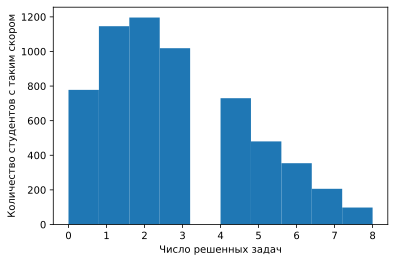

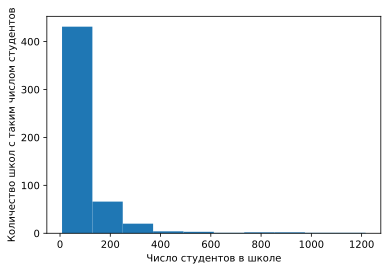

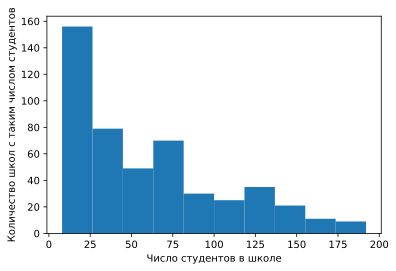

Количество школ, где людей меньше 10: 50, или 9.42%
Подсчет метрики для исходного датафрейма


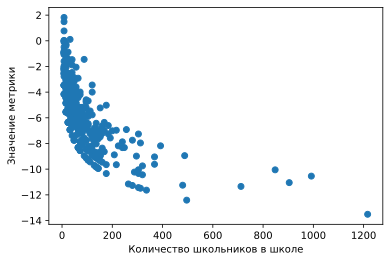

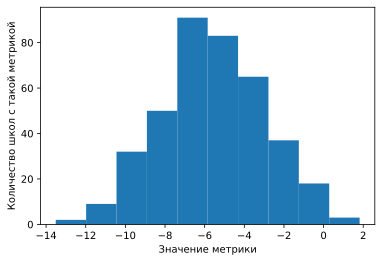

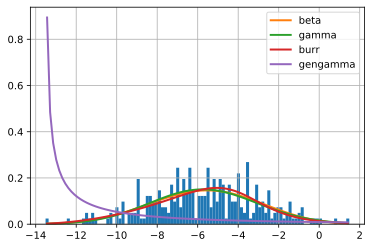

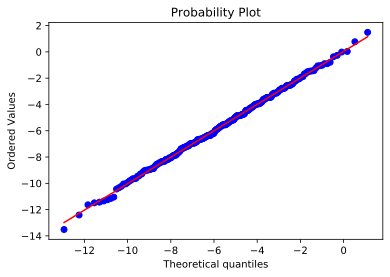

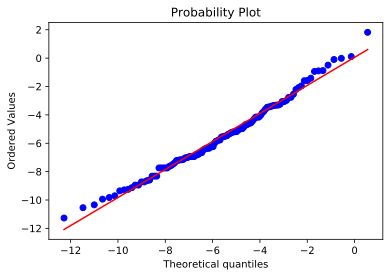

p-value того, что train и test принадлежат одному распределению: 0.9028648797448954
Уровень значимости: 0.05, критическое значение по распределению: -1.375 (область правая)
АА-тестирование с перемешиванием


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:38<00:00,  4.94s/it]


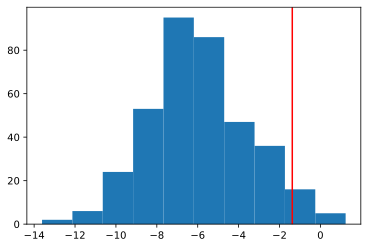

0.95 квантиль для случайных школ: -1.524
Тестирование мощности с перемешиванием


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:14<00:00, 13.45it/s]


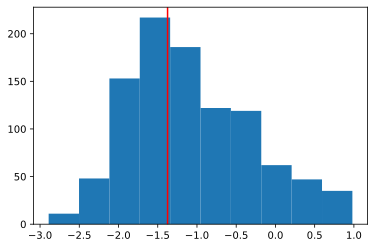

Доля найденных нечестых школ (а-ка мощность): 0.595


,schools,metric_not_logged,metric_logged,pvalue
11,16,6.156250,1.817468,0.000714
100,426,4.421875,1.486564,0.001336
237,361,2.156250,0.768371,0.004320
19,436,1.115234,0.109065,0.010585
115,629,1.031250,0.030772,0.011660
355,370,0.984375,-0.015748,0.012339
65,815,0.984375,-0.015748,0.012339
281,457,0.906250,-0.098440,0.013623
59,437,0.765625,-0.267063,0.016568
104,235,0.687500,-0.374693,0.018695


In [27]:
real_cheat_df_1322 = ultimate_pipeline(data_path, schools_path, rep_aa=20, rep_b=1000)

real_cheat_df_1322